## Importing Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.python.keras import optimizers

import os
import cv2
import math
from IPython.display import clear_output
%matplotlib inline

C:\Users\HO_YONG_KIAN\Anaconda3\envs\tf_object_envir\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\HO_YONG_KIAN\Anaconda3\envs\tf_object_envir\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\HO_YONG_KIAN\Anaconda3\envs\tf_object_envir\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\HO_YONG_KIAN\

In [2]:
print(os.listdir("data/img_data"))
print(os.listdir("data/video_data"))

['test', 'train']
['test_videos', 'train_videos']


## Data Preparation

The footage used for training and testing is downloaded from Youtube and compiled from different github repositories that are working on similar projects. The training/test data is split between 75%/25% andit is categorised into 3 classes: default, fire and smoke while the videos are labeled in their file names

In [3]:
IMG_SIZE = 224
NUM_EPOCHS = 20
NUM_CLASSES = 3
TRAIN_BATCH_SIZE = 77
TEST_BATCH_SIZE = 1

In [4]:
print(os.listdir("data/img_data/train"))
print(os.listdir("data/video_data/train_videos"))

['default', 'fire', 'smoke']
['fire and smoke.mp4', 'fire1.mp4', 'fire2.mp4', 'fire3.mp4', 'fire4.mp4', 'newsmoke1.mp4', 'newsmoke2.mp4', 'nofire1.mp4', 'nofire2.mp4', 'smoke1.mp4', 'smoke2.mp4', 'smoke5.mp4']


## VGG16 & Resnet50 model

In [5]:
def create_model(model_size="VGG"):
    model = Sequential()
    if model_size == "VGG":
        vgg = VGG16(include_top=False, weights="imagenet") #don't use this, lacking GPU memory
        vgg.summary()
        model.add(vgg)
        model.add(GlobalAveragePooling2D())
        model.layers[0].trainable = False
        model.layers[1].trainable = False
    elif model_size == "RES":
        resnet = ResNet50(include_top=False, pooling="avg", weights="imagenet")
        resnet.summary()
        model.add(resnet)
        model.layers[0].trainable = False
    
    model.add(Dense(NUM_CLASSES, activation="softmax")) #final layer should have three nodes with softmax activation function for multiclass prediction
    model.compile(optimizer=optimizers.adam(), loss="categorical_crossentropy",metrics=["accuracy", "mse"])
    return model

## Training Data Generator

Functions to pre-process training data

In [6]:
def train_model( model ):
    data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=[0.9, 1.25],
                                horizontal_flip=True,
                                vertical_flip=False,
                                data_format='channels_last',
                                brightness_range=[0.5, 1.5]
                               )
                                       
    train_generator = data_generator_with_aug.flow_from_directory(
            'data/img_data/train',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TRAIN_BATCH_SIZE,
            class_mode='categorical')
    
   
    validation_generator = data_generator_with_aug.flow_from_directory(
            'data/img_data/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TEST_BATCH_SIZE,
            shuffle = False,
            class_mode='categorical')
       
    history = model.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.n/TRAIN_BATCH_SIZE,
            epochs=NUM_EPOCHS,
            validation_data=validation_generator,
            validation_steps=1)

    return model, train_generator, validation_generator, history

def get_label_dict(train_generator):
    labs = (train_generator.class_indices)
    labs_dict = dict((v,k) for k,v in labs.items())
    return labs_dict

def get_labels(generator):
    generator.reset()
    labs = []
    for i in range(len(generator)):
        labs.extend(np.array(generator[i][1]))
    return np.argmax(labels, axis=1)

def get_pred_labels(test_generator):
    test_generator.reset()
    pred_vec=model.predict_generator(test_generator,
                                     steps=test_generator.n,
                                     verbose=1)
    return np.argmax(pred_vec, axis=1), np.max(pred_vec, axis=1)

def plot_history(history, NUM_EPOCHS):
    plt.style.use("ggplot")
    fig = plt.figure()
    fig.set_size_inches(15, 5)
    
    fig.add_subplot(1, 3, 1)
    plt.plot(np.arange(0, NUM_EPOCHS), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Validation Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")

    
    fig.add_subplot(1, 3, 2)
    plt.plot(np.arange(0, NUM_EPOCHS), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), history.history["acc"], label="train_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    fig.add_subplot(1, 3, 3)
    plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_acc"], label="val_acc")
    plt.title("Validation Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")


    plt.show()

## Training the VGGmodel

In [7]:
def draw_prediction(frame, class_string):
    x_start = frame.shape[1] -600
    cv2.putText(frame, class_string, (x_start, 75), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (255, 0, 0), 2, cv2.LINE_AA)
    return frame

In [8]:
def prepare_image_for_prediction(img):
    img = np.expand_dims(img, axis=0)
    return preprocess_input(img)

In [22]:
model = create_model(model_size="RES")

In [23]:
trained_model, train_generator, test_generator, history = train_model(model)
label_dict = get_label_dict(train_generator)

Found 693 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Epoch 1/20
9/9 [==============================] - 25s 3s/step - loss: 1.0950 - acc: 0.4661 - mean_squared_error: 0.2154 - val_loss: 2.6874 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.4976
Epoch 2/20
9/9 [==============================] - 19s 2s/step - loss: 0.5958 - acc: 0.7893 - mean_squared_error: 0.1101 - val_loss: 1.6239 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.3876
Epoch 3/20
9/9 [==============================] - 20s 2s/step - loss: 0.4193 - acc: 0.8571 - mean_squared_error: 0.0754 - val_loss: 1.2498 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.2646
Epoch 4/20
9/9 [==============================] - 20s 2s/step - loss: 0.3305 - acc: 0.8947 - mean_squared_error: 0.0579 - val_loss: 1.0349 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.2093
Epoch 5/20
9/9 [==============================] - 21s 2s/step - loss: 0.2789 - acc: 0.9062 - mean_squared_error: 0.0492 - val_loss: 2.1514 - v

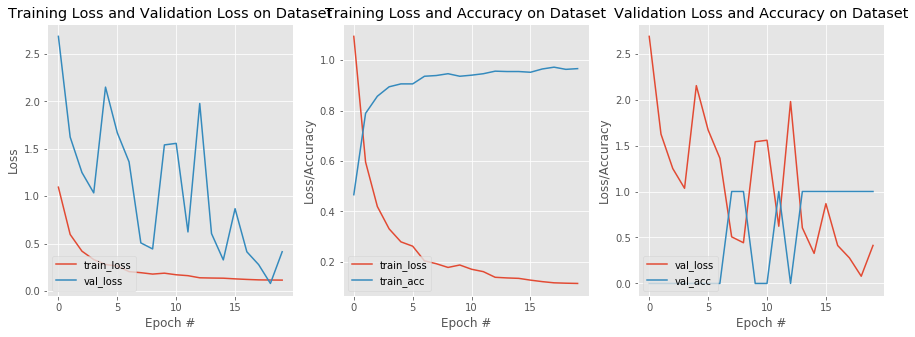

In [24]:
plot_history(history=history, NUM_EPOCHS=NUM_EPOCHS)

In [25]:
trained_model.save("trained_resnet.h5")

In [9]:
from tensorflow.keras.models import load_model
resnet_model = load_model('trained_resnet.h5')
resnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________


## Prediction Function

In [10]:
def get_display_string(pred_class, label_dict):
    txt = ""
    for c, confidence in pred_class:
        txt += label_dict[c]
        if c :
            txt += '['+ str(confidence) +']'
    return txt

In [11]:
def predict(model, video_path, filename, label_dict):
    vs = cv2.VideoCapture(video_path)
    fps = math.floor(vs.get(cv2.CAP_PROP_FPS))
    ret_val = True
    writer = 0
    
    while True:
        ret_val, frame = vs.read()
        if not ret_val:
            break
        resized_frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frame_for_pred = prepare_image_for_prediction( resized_frame )
        pred_vec = model.predict(frame_for_pred)
        pred_class =[]
        confidence = np.round(pred_vec.max(),2) 
        
        if confidence > 0.4:
            pc = pred_vec.argmax()
            pred_class.append( (pc, confidence) )
            if pc == "smoke":
                return "smoke"
            if pc == "default":
                return "default"
            if pc == "fire":
                return "fire"
        else:
            pred_class.append( (0, 0) )
            
        if pred_class:
            txt = get_display_string(pred_class, label_dict)       
            frame = draw_prediction( frame, txt )
        if not writer:
            fourcc = cv2.VideoWriter_fourcc(*"XVID")
            writer = cv2.VideoWriter(filename, fourcc, fps,(frame.shape[1], frame.shape[0]), True)
            
        # write the out
        writer.write(frame)
        
        cv2.imshow("Output", frame)
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord("q"):
            break
        
    vs.release()
    writer.release()

In [12]:
video_path = 'data/video_data/test_videos/test4.avi'
predict (model=trained_model, video_path=video_path, filename='test1_9.avi', label_dict=label_dict) 

#video_path = 'data/video_data/test_videos/test2.mp4'
#predict (model=trained_model, video_path=video_path, filename='test2_9.avi',  label_dict=label_dict) 

#video_path = 'data/video_data/test_videos/test3.mp4'
#predict (model=trained_model, video_path=video_path, filename='test3_9.avi',  label_dict=label_dict)

NameError: name 'trained_model' is not defined

In [14]:
label_dict = {0: 'default', 1: 'fire', 2: 'smoke'}
video_path = 'data/video_data/test_videos/test4.avi'
predict (model=resnet_model, video_path=video_path, filename='test1_9.avi', label_dict=label_dict) 